In [115]:
import sys 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
       # print(os.path.join(dirname, filename))
        pass
    

# **import libraries**

In [116]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
import random
import cv2
warnings.filterwarnings("ignore")
print(tf.__version__)

2.15.0


# load data and vis 

In [117]:
#skin_cancer_data = train dataset  not all data
Skin_cancer_data='/kaggle/input/skin-cancer-malignant-vs-benign/train'
labels_list=os.listdir(Skin_cancer_data)#This line tries to read all the subdirectories present 
labels_list #This code snippet only retrieves folder names, it doesn't access the actual image data.

['benign', 'malignant']

In [118]:
images=[]
labels=[]

for i in labels_list:
    path=os.path.join(Skin_cancer_data,i)
#Extracting image filenames:
    for img in os.listdir(path):
        image_path=os.path.join(path,img)
        images.append(image_path)
        labels.append(i)
print(images[0])
print(labels[0])

/kaggle/input/skin-cancer-malignant-vs-benign/train/benign/764.jpg
benign


In [119]:
# convert fills to  table dataset 
#  'images' and 'labels' are your lists of images and labels 
df = pd.DataFrame({"images": images, "labels": labels})

# Creating a binary label column based on whether the label is "malignant" or not
df['label_binary'] = np.where(df["labels"].values == "malignant", 1, 0)

# Displaying the first few rows of the DataFrame
df.head()



,images,labels,label_binary
0,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
1,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
2,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
3,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
4,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0


In [120]:
df.tail()

,images,labels,label_binary
2632,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,1
2633,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,1
2634,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,1
2635,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,1
2636,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,1


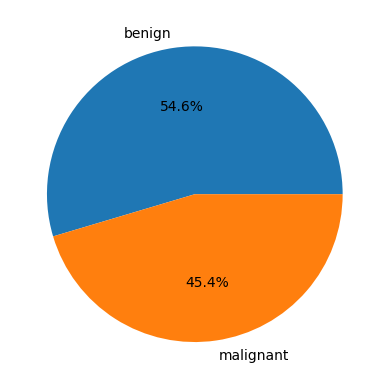

In [121]:
x = df['labels'].value_counts()
plt.pie(x.values,labels=x.index,autopct='%1.1f%%')
plt.show()


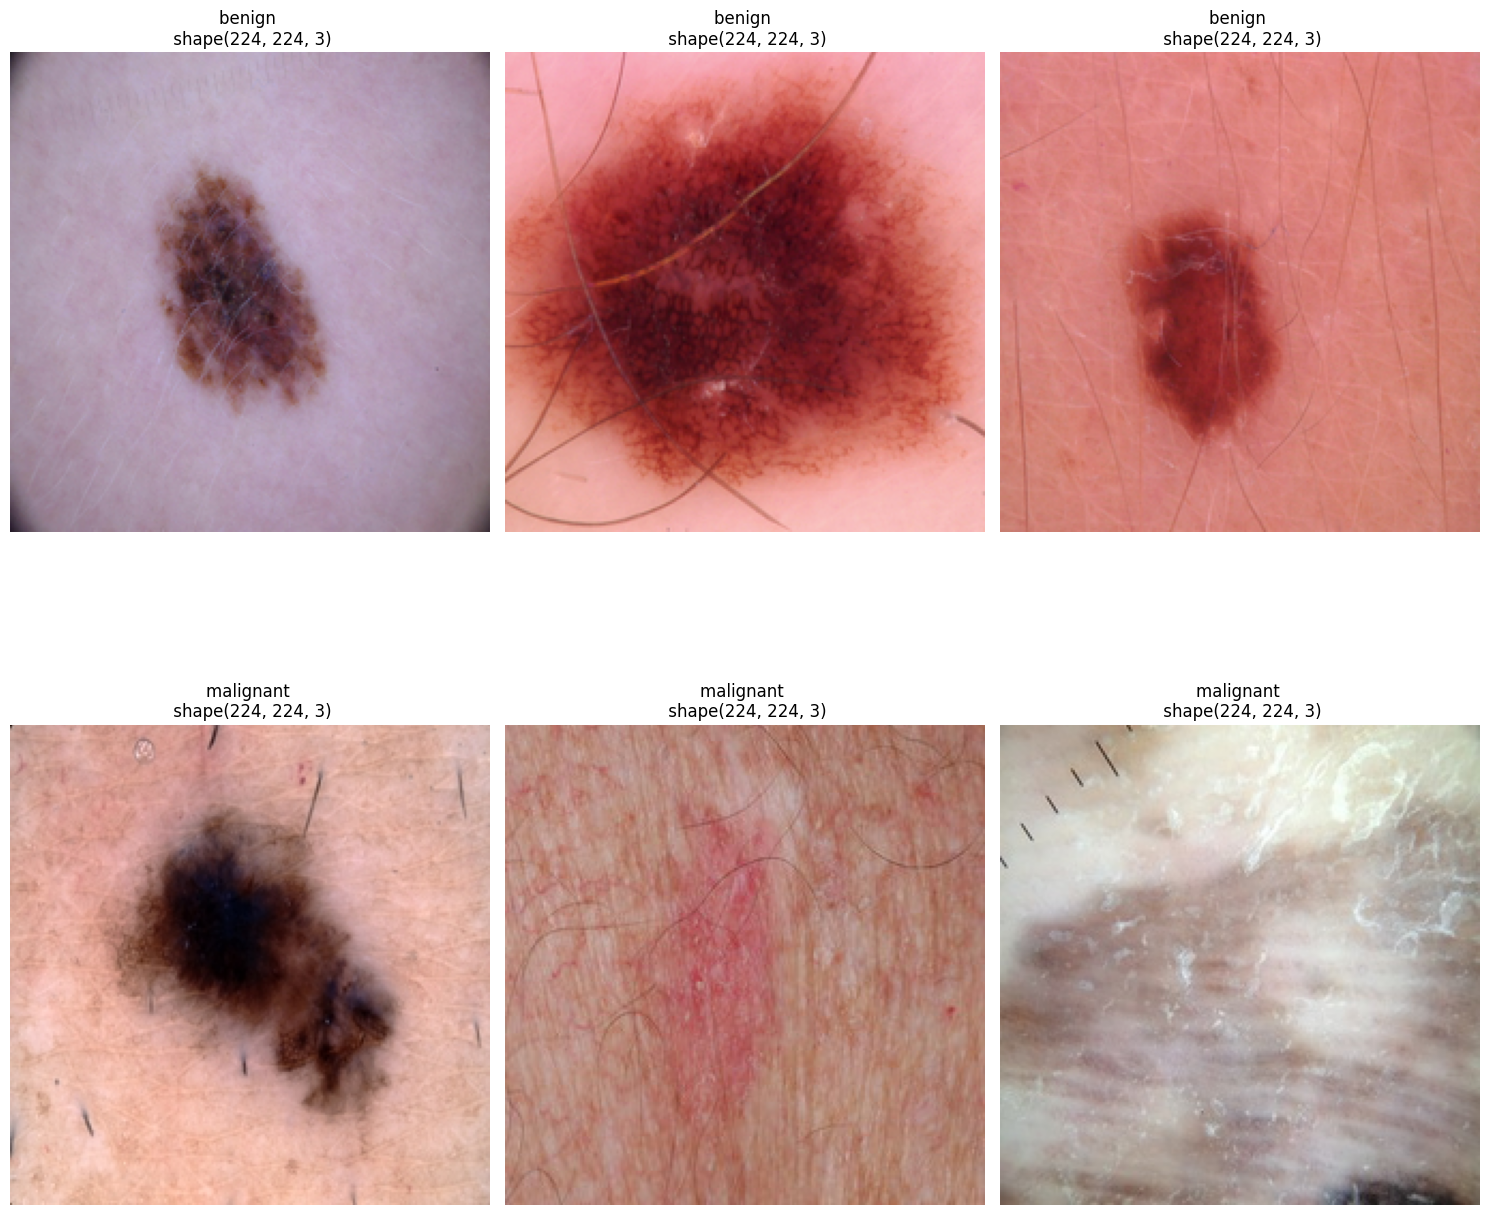

In [122]:
# display random images 
fig,ax=plt.subplots(2,3,figsize=(15,15))
p=0
for label in labels_list:

    img=df["images"][df["labels"]==label]
    select_images= random.choices(img.values,k=3)

    for i,img in enumerate(select_images):
        im=cv2.imread(img)
        im_rgb=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(im_rgb)
        ax[p,i].set_title(f"{label} \n shape{im_rgb.shape}")
        ax[p,i].axis("off")

    p+=1
fig.tight_layout()
fig.show()

# **Image Preprocessing And Augmentation **

In [123]:
#data preprocessing and augmentation during training 
#shear_range=0.2, This randomly applies a shearing transformation to the image.
#zoom_range=0.2, This randomly applies a zooming to the image. 
#horizontal_flip=True, This randomly applies  a horizontal and vertical flip 
train_data_gen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True, vertical_flip=True)

test_data_gen = ImageDataGenerator(rescale=1./255)


In [124]:
# Load and preprocess training data
training_set = train_data_gen.flow_from_directory('/kaggle/input/skin-cancer-malignant-vs-benign/train',
                                                 target_size=(64,64),#resizes all images to a uniform size of 64x64 pixels.
                                                 batch_size=32,  #the number of images processed by the model at each training step
                                                 class_mode='binary')

# Load and preprocess test data
test_set = test_data_gen.flow_from_directory('/kaggle/input/skin-cancer-malignant-vs-benign/test',
                                            target_size=(64,64),
                                            batch_size=32,
                                            class_mode='binary')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [125]:
# the output  image shape  = (height,width,RGB)
training_set.image_shape

(64, 64, 3)

# Building CNN layers + NN 

In [126]:
#define CNN layers
model=Sequential()

# Convolutional layers
model.add(Convolution2D(64,(3,3),input_shape=(64,64,3),activation='relu'))# defines a 2D convolutional layer with 64 filters of size 3x3.  specifies the expected input image shape (input_shape)                                                                        
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#flatten layer
model.add(Flatten())

#fully connected layers
model.add(Dense(units=128,activation="relu"))#Adds a fully connected layer with 128 neurons and ReLU activation
model.add (Dense(units=64,activation="relu"))
#model.(Dropout(0.3)
model.add(Dense(units=1,activation='sigmoid')) # #Adds the final output layer with 1 neuron and sigmoid activation (suitable for binary classification).

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [127]:
print(model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 62, 62, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 29, 29, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 379,009 (1.45 MB)

 Trainable params: 379,009 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

None


# **Train the model**


In [128]:
#step_per_epoch= 1440(number of data-train)/ 32 (batch-size)
history = model.fit(training_set,
                    steps_per_epoch=45,
                    epochs=5,
                    validation_data=test_set)

Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 260ms/step - accuracy: 0.5832 - loss: 0.6667 - val_accuracy: 0.7485 - val_loss: 0.6068
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.7366 - loss: 0.5629 - val_accuracy: 0.7167 - val_loss: 0.5736
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 237ms/step - accuracy: 0.7713 - loss: 0.5015 - val_accuracy: 0.7742 - val_loss: 0.4220
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - accuracy: 0.7668 - loss: 0.4602 - val_accuracy: 0.7939 - val_loss: 0.3941
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step - accuracy: 0.7743 - loss: 0.4616 - val_accuracy: 0.7955 - val_loss: 0.4420


# **Plot training history**

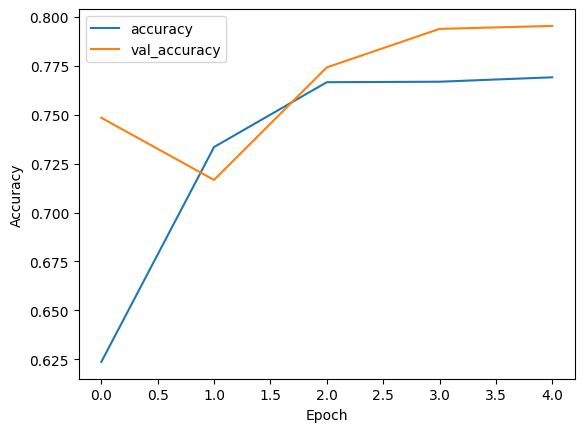

In [129]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [130]:
test_loss, test_acc = model.evaluate(test_set, steps=5)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7699 - loss: 0.4403
Test accuracy: 0.7562500238418579
Test loss: 0.44711002707481384


# Testing

In [131]:
from keras.preprocessing import image

# Load image
test_image_path = "/kaggle/input/skin-cancer-malignant-vs-benign/test/malignant/1.jpg"
test_image = image.load_img(test_image_path, target_size=(64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

# Predict
result = model.predict(test_image)

# Define class indices
class_indices = {'benign': 0, 'malignant': 1}

# Interpret prediction
if result[0][0] == 0:
    prediction = "benign"
else:
    prediction = "malignant"

# Print prediction result
print("The prediction result is:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
The prediction result is: malignant


In [132]:
# Load image
test_image_path = "/kaggle/input/skin-cancer-malignant-vs-benign/test/benign/1029.jpg"
test_image = image.load_img(test_image_path, target_size=(64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

# Predict
result = model.predict(test_image)

# Define class indices
class_indices = {'benign': 0, 'malignant': 1}

# Interpret prediction
if result[0][0] == 0:
    prediction = "benign"
else:
    prediction = "malignant"

# Print prediction result
print("The prediction result is:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The prediction result is: benign
